<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/speaker_indep_bigru_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!pip install fastdtw
!pip install pysptk      
!pip install pyworld

## Obtaining the data

In [ ]:
import shutil
from google.colab import drive
import zipfile

# IMPORTANT: In the case that wget throws a '429 ERROR' (sometimes it denies the request), please contact us, and we will grant you access to the needed files
# Then by setting the 'drive_need' variable to true, you can obtain the files via our drive
drive_need = False

if drive_need == True:
  drive.mount('/content/drive')
  # Data extraction
  
  zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DeepLearning/features.zip", 'r')
  zip_ref.extractall("/content/features")
  zip_ref.close()

  # Original electrode name extraction
  zip_ref = zipfile.ZipFile("/content/drive/MyDrive/DeepLearning/subject_channels.zip", 'r')
  zip_ref.extractall("/content")
  zip_ref.close()

  # Copying the modules into the base directory
  shutil.copyfile("/content/drive/MyDrive/DeepLearning/MelFilterBank.py", "/content/MelFilterBank.py")
  shutil.copyfile("/content/drive/MyDrive/DeepLearning/reconstructWave.py", "/content/reconstructWave.py")


In [ ]:
#features
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp" -O features.zip && rm -rf /tmp/cookies.txt
#original electrode names
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1hBr7KNrNNl9udDB8OQ0nKt2LD0WfxJ7K' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1hBr7KNrNNl9udDB8OQ0nKt2LD0WfxJ7K" -O subject_channels.zip && rm -rf /tmp/cookies.txt
#reconstruction module
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP" -O reconstructWave.py && rm -rf /tmp/cookies.txt
#Melfiltebank applier
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog" -O MelFilterBank.py && rm -rf /tmp/cookies.txt


# Data extraction
import zipfile
zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
zip_ref.extractall("/content/features")
zip_ref.close()

# Electrode name extraction
zip_ref = zipfile.ZipFile("/content/subject_channels.zip", 'r')
zip_ref.extractall("/content")
zip_ref.close()


--2022-12-10 08:26:05--  https://docs.google.com/uc?export=download&confirm=&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp
Resolving docs.google.com (docs.google.com)... 172.217.219.101, 172.217.219.138, 172.217.219.102, ...
Connecting to docs.google.com (docs.google.com)|172.217.219.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6tht3df23fglhscdumjj79bbldbcprpf/1670660700000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=64830157-7344-494e-871c-1f9758982ac2 [following]
--2022-12-10 08:26:12--  https://doc-08-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6tht3df23fglhscdumjj79bbldbcprpf/1670660700000/17895932938140350971/*/1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp?e=download&uuid=64830157-7344-494e-871c-1f9758982ac2
Resolving doc-08-9o-docs.googleusercontent.com (doc-08-9o-docs.googleusercontent.com)... 172.217.212.1

BadZipFile: ignored

<h3>Preparations and needed functions</h3>

Our plan is to transform every feature vector into a larger dimensional feature vector, which contains all the different electrode names across all the subjects. In the original features, every feature vector consisted of 9 smaller feature vectors which corresponded to the transformed iEEG signals across 9 consecutive timesteps, so every feature vector had some sort of sequentiality within itself. So in order to use BiGRU and Convolutional models effectively, we need to be specific about the ordering of our features.


In [ ]:
import pandas as pd
import numpy as np


# Getting the original electrode names
original_electrodes = set()

for subject in ['01','02','03','04','05','06','07','08','09','10']:
  table = pd.read_csv(f'/content/subject_channels/sub-{subject}_task-wordProduction_channels.tsv', sep='\t')
  elecs = set(table['name'])
  original_electrodes = original_electrodes.union(elecs)


# Now indexing them from -4 to 4 in order, so all features vectors will consist of 9 smaller feature vectors which will correspond to the
# 9 consecutive timesteps in the larger dimensional vectors (every step will have 540 channels)
all_electrodes = []
for i in range(9):
  for elec in original_electrodes:
    all_electrodes.append(elec + "T" + str(i-4))


print('Number of different features:', len(all_electrodes))

#we will use this list's indexes to correspond to the feature matrices
all_electrodes = list(all_electrodes) 

Number of different features: 4860


In [ ]:
# Function for making every feature vector into a 4860 dimensional vector

def dim_adjust(data, feature_names):
  #create a new matrix with zeros, insert the values into the columns
  #which correspond to the subject's feature names, then concatenate them

  new_matrix = np.zeros((data.shape[0],len(all_electrodes)))
  for column in range(data.shape[1]):
    insert_index = all_electrodes.index(feature_names[column])
    new_matrix[:,insert_index] = data[:,column]
    
  return new_matrix


## Making the iterated test, validation and test sets

In [ ]:
import os

feat_path = "/content/features"

# Function to generate the train, val and test features and mel spectrograms

def generate_features_and_spec():
  #Base arrays
  train_feat = np.empty((0, len(all_electrodes)))
  val_feat = np.empty((0, len(all_electrodes)))
  test_feat = np.empty((0, len(all_electrodes)))

  train_spec = np.empty((0, 23))
  val_spec = np.empty((0, 23))
  test_spec = np.empty((0, 23))

  # List of tuples, each will contain 4 indexes: (test_beg, test_end, orig_beg, orig_end), 
  # This is for keeping track of which part of the test set corresponds to which part of each subject's spectrogram
  test_indices=[]
  # Noting the current length of the test set to calculate the indeces for the list above
  len_test = 0


  for index, subject in enumerate(['01','02','03','04','05','06','07','08','09','10']):
    #loading the features, feature names and mel spectrogram of the subject
    data = np.load(os.path.join(feat_path,f'sub-{subject}_feat.npy'))
    feature_names = np.load(os.path.join(feat_path,f'sub-{subject}_feat_names.npy'))
    spectrogram = np.load(os.path.join(feat_path,f'sub-{subject}_spec.npy'))

    #splittig the features and the labels into 5 parts
    feat_splits = np.array_split(data, 5)
    spec_splits = np.array_split(spectrogram, 5)

    #making the train, val or test arrays for the subject using a 60-20-20 ratio
    #because of the "index" changing, the splitting position will iterate with each subject as well
    subject_train_feat = np.vstack((feat_splits[index % 5],feat_splits[(index+1) % 5],feat_splits[(index+2) % 5]))
    subject_train_spec = np.vstack((spec_splits[index % 5],spec_splits[(index+1) % 5],spec_splits[(index+2) % 5]))

    subject_val_feat = feat_splits[(index+3) % 5]
    subject_val_spec = spec_splits[(index+3) % 5]

    subject_test_feat = feat_splits[(index+4) % 5]
    subject_test_spec = spec_splits[(index+4) % 5]

    #getting the indeces
    all_test_indeces = np.array_split(np.array([i for i in range(spectrogram.shape[0])]), 5)[(index+4) % 5]
    test_beg = len_test
    test_end = len_test+subject_test_spec.shape[0]-1
    orig_beg = all_test_indeces[0]
    orig_end = all_test_indeces[-1]

    test_indices.append((test_beg, test_end, orig_beg, orig_end))
    len_test = len_test+subject_test_spec.shape[0]


    #concatenating the dimensionality-adjusted features with the pre-existing feature set
    train_feat = np.concatenate((train_feat, dim_adjust(subject_train_feat, feature_names)))
    val_feat = np.concatenate((val_feat, dim_adjust(subject_val_feat, feature_names)))
    test_feat = np.concatenate((test_feat, dim_adjust(subject_test_feat, feature_names)))

    #concatenating the appropriate arrays with the pre-existing train, val or test labels
    train_spec = np.concatenate((train_spec, subject_train_spec))
    val_spec = np.concatenate((val_spec, subject_val_spec))
    test_spec = np.concatenate((test_spec, subject_test_spec))

  return train_feat, train_spec, val_feat, val_spec, test_feat, test_spec, test_indices 

# Generating the data
train_feat, train_spec, val_feat, val_spec, test_feat, test_spec, test_indices = generate_features_and_spec()

In [ ]:
from sklearn.preprocessing import StandardScaler
# Scaling the data 

scaler = StandardScaler()
scaler.fit(train_feat)
train_feat = scaler.transform(train_feat)
val_feat = scaler.transform(val_feat)
test_feat = scaler.transform(test_feat)

In [ ]:
# Reshaping the data for the sequential models

train_feat = np.reshape(train_feat, (train_feat.shape[0], 9, int(train_feat.shape[1]/9)))
val_feat = np.reshape(val_feat, (val_feat.shape[0], 9, int(val_feat.shape[1]/9)))
test_feat = np.reshape(test_feat, (test_feat.shape[0], 9, int(test_feat.shape[1]/9)))

# Fine tuning the models

<h3>Defining the data generators</h3>

In [ ]:
from tensorflow.keras.utils import Sequence, set_random_seed

set_random_seed(1234)

class DataGenerator(Sequence):
    # Initialization
    def __init__(self, data, spec, batch_size=32, dim=(9, 540), shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.data = data
        self.shuffle = shuffle
        self.spec = spec
        self.on_epoch_end()

    def __len__(self):
        # Shows the number of batches per epoch
        return int(np.floor(self.data.shape[0] / self.batch_size))

    def __getitem__(self, index):
        # Generate one batch of data
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        X_batch = np.empty((self.batch_size, self.dim[0], self.dim[1]))
        y_batch = np.empty((self.batch_size, 23))
        for index1, elem in enumerate(indexes):
          X_batch[index1] = self.data[elem]
          y_batch[index1] = self.spec[elem]

        return X_batch, y_batch

    def on_epoch_end(self):
        # Updating the index after each epoch
        self.indexes = np.arange(self.data.shape[0])
        if self.shuffle == True:
            np.random.shuffle(self.indexes)


# Creating the generator
train_gen = DataGenerator(train_feat, train_spec, 256)
val_gen = DataGenerator(val_feat, val_spec, 256)

<h3>Tuning the BiGRU model</h3>

In [ ]:
%%capture
!pip install keras-tuner

In [ ]:
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Input, Dropout, Bidirectional, GRU, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import keras_tuner as kt


def create_bigru_optimal(hp):

  model = tf.keras.Sequential()
  model.add(Input(shape=(9, 540)))

  # Recurrent layer 1
  hp_units_1 = hp.Int('units_1', min_value=128, max_value=512, step=64)
  hp_dropout_1 = hp.Float('dropout_1', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Bidirectional(GRU(units=hp_units_1, return_sequences=True, dropout=hp_dropout_1)))

  # Recurrent layer 2
  hp_units_2 = hp.Int('units_2', min_value=64, max_value=256, step=32)
  hp_dropout_2 = hp.Float('dropout_2', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Bidirectional(GRU(units=hp_units_2, return_sequences=True, dropout=hp_dropout_2)))

  # Recurrent layer 3
  hp_units_3 = hp.Int('units_3', min_value=16, max_value=64, step=8)
  hp_dropout_3 = hp.Float('dropout_3', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Bidirectional(GRU(units=hp_units_3, return_sequences=True, dropout=hp_dropout_3)))

  # Final layers
  model.add(Flatten())
  hp_dense_units = hp.Int('units_dense', min_value=128, max_value=512, step=64)
  hp_dropout_4 = hp.Float('dropout_4', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  hp_activation = hp.Choice('activation', values=['relu', 'swish'])

  model.add(Dense(hp_dense_units, activation = hp_activation, kernel_initializer='HeNormal'))
  model.add(Dropout(rate=hp_dropout_4))
  model.add(Dense(23, activation = 'linear'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model


In [ ]:
# Setting up the tuner for the BiGRU model
tuner_bigru = kt.Hyperband(create_bigru_optimal,
                     objective='val_loss',
                     max_epochs=15,
                     factor = 3,
                     seed = 42,
                     directory='/content/bigru_opt',
                     project_name='bigru_opt1')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Note: takes about 60 minutes to optimize
stop_early = EarlyStopping(monitor='val_loss', patience=8)
tuner_bigru.search(train_gen, epochs=100, validation_data=(val_feat, val_spec), verbose=0, shuffle=True, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_bigru=tuner_bigru.get_best_hyperparameters(num_trials=1)[0]

<h3>Tuning the Convolutional model</h3>

In [ ]:
def create_conv_optimal(hp):
  model = tf.keras.Sequential()

  # 1st conv
  hp_filter_1 = hp.Int('filter_1', min_value=16, max_value=64, step=8)
  hp_kernel_1 = hp.Choice('kernel_1', values=[2,3,4])
  hp_activation_1 = hp.Choice('activation_1', values=['relu', 'swish'])
  model.add(Conv1D(filters=hp_filter_1, kernel_size=hp_kernel_1, activation=hp_activation_1, kernel_initializer='HeNormal', input_shape=(9, 540)))

  hp_dropout_1 = hp.Float('dropout_1', min_value = 0.0, max_value = 0.5, default = 0.2, step = 0.1)
  model.add(Dropout(rate=hp_dropout_1))

  # 2nd conv
  hp_filter_2 = hp.Int('filter_2', min_value=32, max_value=128, step=16)
  hp_kernel_2 = hp.Choice('kernel_2', values=[2,3,4])
  hp_activation_2 = hp.Choice('activation_1', values=['relu', 'swish'])
  model.add(Conv1D(filters=hp_filter_2, kernel_size=hp_kernel_2, activation=hp_activation_2, kernel_initializer='HeNormal'))

  # Last layer
  model.add(MaxPooling1D(pool_size=2))
  model.add(Flatten())
  #hp_dense_units = hp.Int('units_dense', min_value=32, max_value=64, step=8)
  #hp_activation = hp.Choice('activation', values=['relu', 'swish'])
  #model.add(Dense(hp_dense_units, activation = hp_activation, kernel_initializer='HeNormal'))
  model.add(Dense(units=23, activation='linear'))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model



In [ ]:
# Setting up the tuner for the convolutional model
tuner_conv = kt.Hyperband(create_conv_optimal,
                     objective='val_loss',
                     max_epochs = 20,
                     factor = 3,
                     seed = 42,
                     directory='/content/conv_opt',
                     project_name='conv_opt1')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Note: takes about 20-30 minutes to optimize
stop_early = EarlyStopping(monitor='val_loss', patience=10)
tuner_conv.search(train_gen, epochs=100, validation_data=(val_feat, val_spec), verbose=0, shuffle=True, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps_conv=tuner_conv.get_best_hyperparameters(num_trials=1)[0]

# Training the tuned models

<h3>BiGRU</h3>

In [ ]:
# Fitting and retraining the model with the best params
model_bigru = tuner_bigru.hypermodel.build(best_hps_bigru)

early_stopping=EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

history_bigru = model_bigru.fit(train_gen, epochs=100, verbose=1, validation_data=(val_feat, val_spec), callbacks=[checkpointer, early_stopping])

Epoch 1/100
698/699 [============================>.] - ETA: 0s - loss: 1.5013 - mse: 1.5013
Epoch 1: val_loss improved from inf to 4.41534, saving model to weights1.hdf5
699/699 [==============================] - 31s 23ms/step - loss: 1.5007 - mse: 1.5007 - val_loss: 4.4153 - val_mse: 4.4153
Epoch 2/100
697/699 [============================>.] - ETA: 0s - loss: 0.5564 - mse: 0.5564
Epoch 2: val_loss improved from 4.41534 to 4.07965, saving model to weights1.hdf5
699/699 [==============================] - 15s 21ms/step - loss: 0.5570 - mse: 0.5570 - val_loss: 4.0796 - val_mse: 4.0796
Epoch 3/100
699/699 [==============================] - ETA: 0s - loss: 0.4378 - mse: 0.4378
Epoch 3: val_loss did not improve from 4.07965
699/699 [==============================] - 15s 22ms/step - loss: 0.4378 - mse: 0.4378 - val_loss: 4.1356 - val_mse: 4.1356
Epoch 4/100
697/699 [============================>.] - ETA: 0s - loss: 0.3719 - mse: 0.3719
Epoch 4: val_loss did not improve from 4.07965
699/699 [

In [ ]:
# Prediction on the test set
pred_bigru = model_bigru.predict(test_feat)

1865/1865 [==============================] - 11s 5ms/step


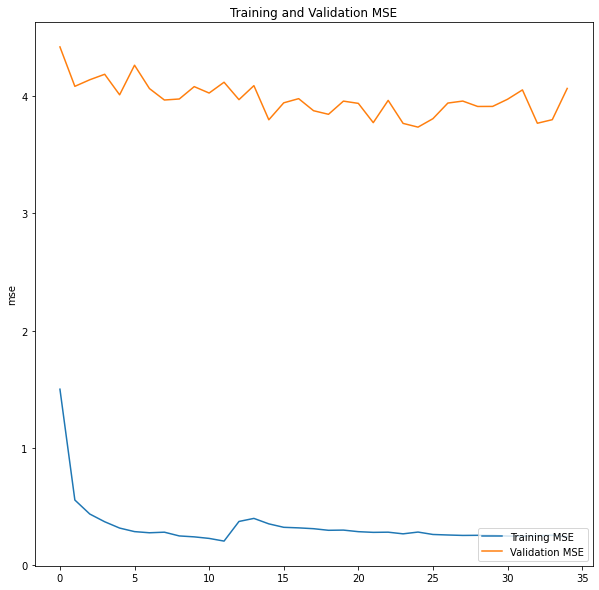

In [ ]:
# Visualizing the train and the validation loss
import matplotlib.pyplot as plt

mse_bigru = history_bigru.history['mse']
val_mse_bigru = history_bigru.history['val_mse']

plt.figure(figsize=(10, 10))
plt.plot(mse_bigru, label='Training MSE')
plt.plot(val_mse_bigru, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.legend(loc='lower right')
plt.ylabel('mse')
plt.show()

<h3>Convolutional network</h2>

In [39]:
# Fitting and retraining the model with the best params
model_conv = tuner_conv.hypermodel.build(best_hps_conv)

early_stopping=EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

history_conv = model_conv.fit(train_gen, epochs=100, verbose=1, validation_data=(val_feat, val_spec), callbacks=[checkpointer, early_stopping])

Epoch 1/100
696/699 [============================>.] - ETA: 0s - loss: 3.0698 - mse: 3.0698
Epoch 1: val_loss improved from inf to 2.51583, saving model to weights1.hdf5
699/699 [==============================] - 12s 17ms/step - loss: 3.0669 - mse: 3.0669 - val_loss: 2.5158 - val_mse: 2.5158
Epoch 2/100
697/699 [============================>.] - ETA: 0s - loss: 2.0250 - mse: 2.0250
Epoch 2: val_loss improved from 2.51583 to 2.25069, saving model to weights1.hdf5
699/699 [==============================] - 8s 11ms/step - loss: 2.0251 - mse: 2.0251 - val_loss: 2.2507 - val_mse: 2.2507
Epoch 3/100
690/699 [============================>.] - ETA: 0s - loss: 1.8135 - mse: 1.8135
Epoch 3: val_loss did not improve from 2.25069
699/699 [==============================] - 8s 12ms/step - loss: 1.8133 - mse: 1.8133 - val_loss: 2.3915 - val_mse: 2.3915
Epoch 4/100
691/699 [============================>.] - ETA: 0s - loss: 1.6514 - mse: 1.6514
Epoch 4: val_loss did not improve from 2.25069
699/699 [==

KeyboardInterrupt: ignored

In [40]:
# Prediction on the test set
pred_conv = model_conv.predict(test_feat)

1865/1865 [==============================] - 3s 2ms/step


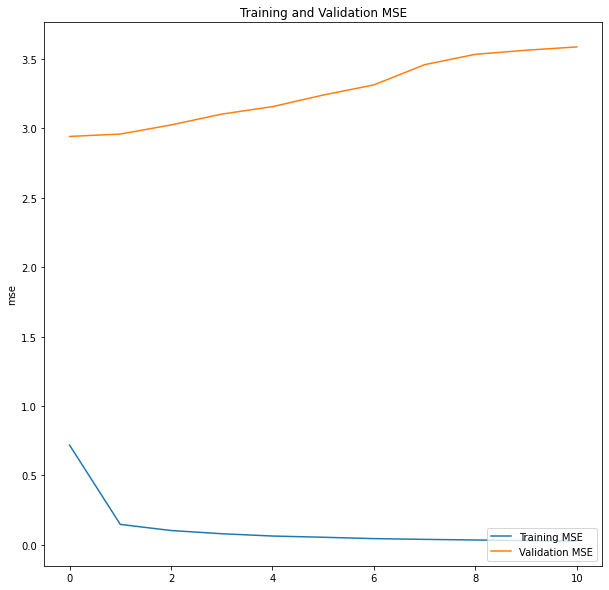

In [ ]:
import matplotlib.pyplot as plt

mse_conv = history_conv.history['mse']
val_mse_conv = history_conv.history['val_mse']

plt.figure(figsize=(10, 10))
plt.plot(mse_conv, label='Training MSE')
plt.plot(val_mse_conv, label='Validation MSE')
plt.title('Training and Validation MSE')
plt.legend(loc='lower right')
plt.ylabel('mse')
plt.show()

# Evaluating the models

<h3>Functions for MCD and audio reconstruction<h3>

In [46]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts a wav file into a format which can be used to evaluate the MCD score
def readmgc(filename):
    sr, x = wavfile.read(filename)
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    print("mgc of {} is ok!".format(filename))
    return mgc


# variable for the compute_mcd function 
natural_folder = '/content/features/'


#this function returns the average MCD score for the reconstructed WAV file by a chosen model
def compute_mcd(synth_folder):
  '''
  :param synth_folder: the folder in which the reconstructed WAV files can be found
  '''

  # computing the MCD
  files = os.listdir(synth_folder)
  for subject in files:
    
    # this is necessary because of the .ipynb_checkpoints files
    if subject.startswith('.'):
      continue

    print("Processing -----------{}".format(subject))

    #computational parameters
    _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
    s = 0.0
    framesTot = 0
    

    # obtaining the mgc features
    subject_ID = subject[0:6]
    filename1 = natural_folder + subject_ID + '_orig_audio.wav'
    mgc1 = readmgc(filename1)
    filename2 = synth_folder + subject_ID + '_predicted.wav'
    mgc2 = readmgc(filename2)
  
    x = mgc1
    y = mgc2
    
    # calculating the mcd
    distance, path = fastdtw(x, y, dist=euclidean)
  
    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()

    MCD_value = _logdb_const * float(s) / float(framesTot)

    print(f"MCD of {subject_ID}: {MCD_value}")



#Small helping function to filter out NaNs and infintes during the reconstruction
def makeNormal(x):
        nanIdx = np.isnan(x)
        x[nanIdx] = 0
        
        infIdx = np.isinf(x)
        x[infIdx] = 0

        return(x)

#Reconstructing the WAV file from the predicted mel-log spectrogram (modified Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    # we needed to change the exponential function to power function
    for_reconstruction = makeNormal(np.dot(np.power(spectrogram, 5), mfb.melInvMatrix))
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    print(scaled)
    return scaled


In [48]:
# Synthesize the audio from the predicted mel spectrograms

!mkdir synth_audio_bigru
!mkdir synth_audio_conv

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

rec_bigru = createAudio(pred_bigru,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bigru/predicted.wav'),int(audiosr),rec_bigru)

rec_conv = createAudio(pred_conv,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_conv/predicted.wav'),int(audiosr),rec_conv)




mkdir: cannot create directory ‘synth_audio_bigru’: File exists
mkdir: cannot create directory ‘synth_audio_conv’: File exists
[0 0 0 ... 0 0 0]


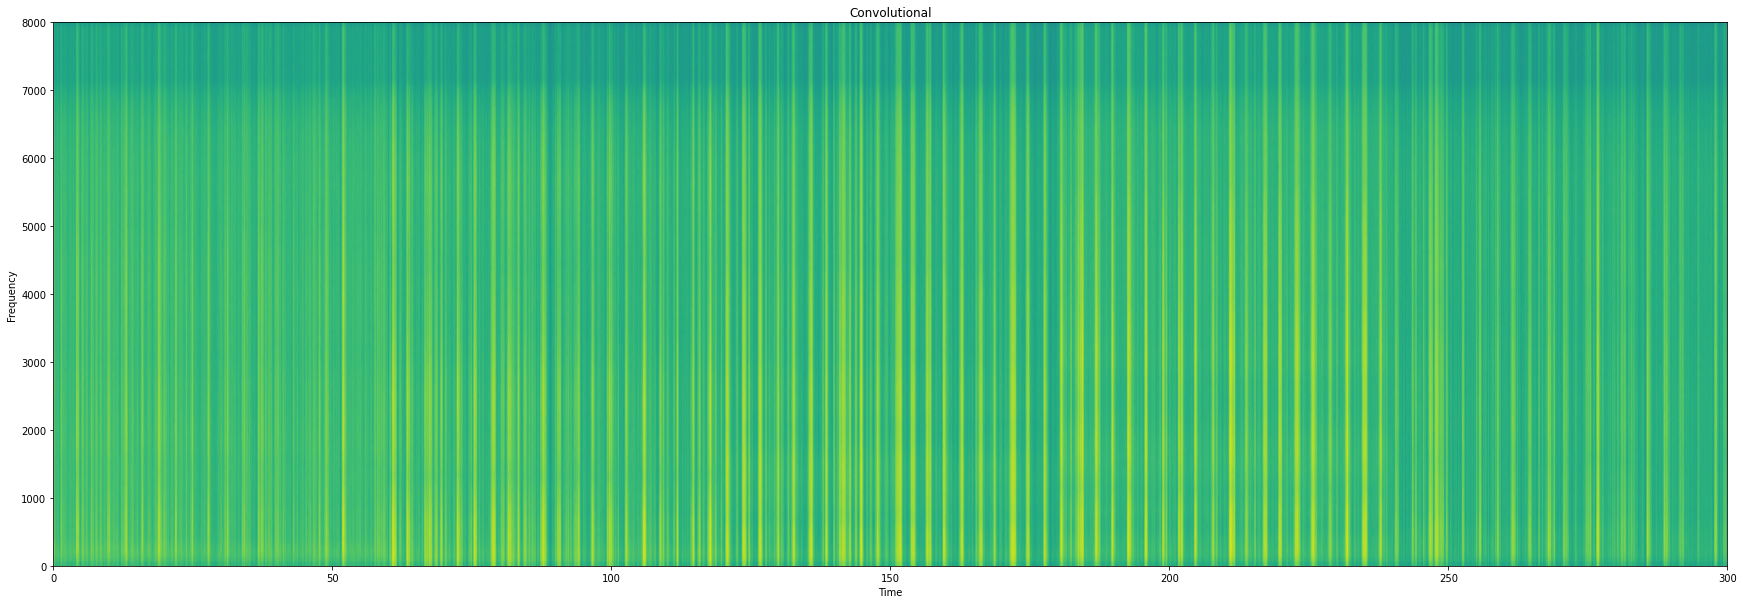

In [49]:
import matplotlib.pyplot as plt
plt.figure(figsize = (30,10))
plt.specgram(rec_conv, Fs=16000)
plt.title('Convolutional')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

Mean Pearson correlation

In [ ]:
# Pearson correlation
from scipy.stats import pearsonr

# BiGRU
corrs_1 = []
for col in range(23):
  r, p = pearsonr(test_spec[:,col], pred_bigru[:,col])
  corrs_1.append(r)
print('For the BiGRU Network, the mean Pearson correlation is:', np.mean(corrs_1))

# Conv
corrs_2 = []
for col in range(23):
  r, p = pearsonr(test_spec[:,col], pred_conv[:,col])
  corrs_2.append(r)
print('For the Convolutional Network, the mean Pearson correlation is:', np.mean(corrs_2))

For the BiGRU Network, the mean Pearson correlation is: -0.003943045580249588
For the Convolutional Network, the mean Pearson correlation is: -0.016025703026708586


RMSE

In [ ]:
from sklearn.metrics import mean_squared_error as mse

print('For the BiGRU Network, the RMSE is:', (mse(test_spec, pred_bigru))**0.5)
print('For the Convolutional Network, the RMSE is:', (mse(test_spec, pred_conv))**0.5)

For the BiGRU Network, the RMSE is: 6.299084266703753
For the Convolutional Network, the RMSE is: 3.164860950304804


Average MCD score

In [ ]:
import librosa
import pyworld

#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav


In [ ]:
#loading the reconstructed spectrograms
rec_conv = load_wav('/content/synth_audio_conv/predicted.wav', 16000)
rec_bigru = load_wav('/content/synth_audio_bigru/predicted.wav', 16000)

In [ ]:
#creating the comparison from parts of the original wav files

aggregated = np.array([])
for index, subject in enumerate(['01','02','03','04','05','06','07','08','09','10']):
  sub_wav = load_wav(os.path.join(feat_path,f'sub-{subject}_orig_audio.wav'), 16000)
  needed_part = np.array_split(sub_wav, 5)[(index+4) % 5]
  aggregated = np.concatenate((aggregated, needed_part))


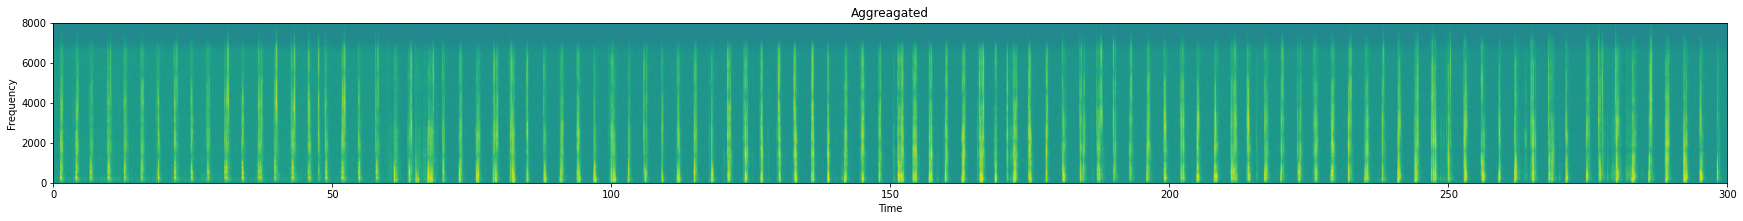

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


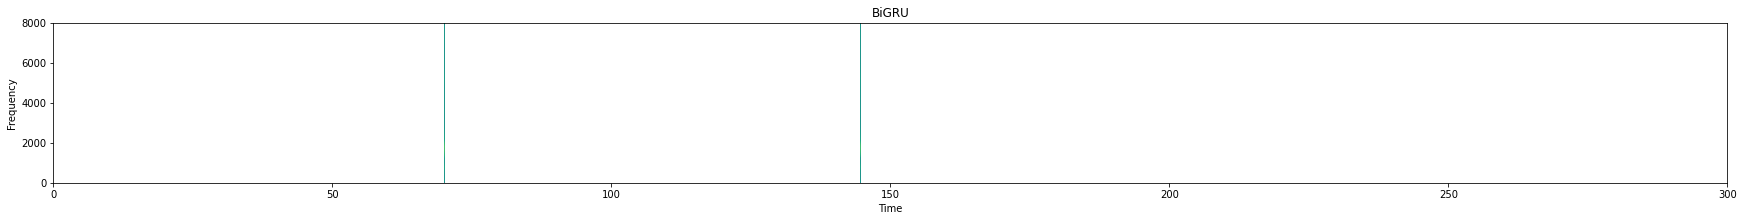

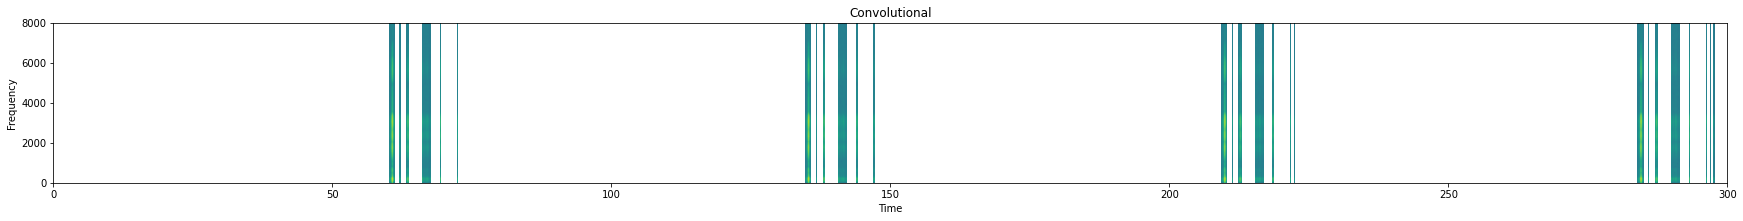

In [ ]:
# Showing the spectrograms

plt.figure(figsize = (30,10))
plt.subplot(311)
plt.specgram(aggregated, Fs=16000)
plt.title('Aggreagated')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(312)
plt.specgram(rec_bigru, Fs=16000)
plt.title('BiGRU')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(313)
plt.specgram(rec_conv, Fs=16000)
plt.title('Convolutional')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()
